# Gather HRRR Atmospheric Data

The purpose of this notebook is to demonstrate the package functions from `gather_HRRR`, intended to build time series of atmospheric observations at an arbitrary longitude/latitude coordinate in North America. The data source is the NOAA HRRR product from AWS. See the list of variables [here](https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfsfcf00.grib2.shtml).

The time series are intended for development and training an ML model of fuel moisture content (FMC). For live deploying an atmospheric model across the country, see the Herbie python package: 

https://github.com/blaylockbk/Herbie/tree/main/herbie 

In [1]:
# Setup
## Packages
import os
import pandas as pd
import numpy as np
import xarray as xr
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt 
import pickle
## Local modules with very literal names
from gather_HRRR import extract_hrrr, gather_hrrr_time_range, download_grib

In [2]:
# Time period of 6 hours in June 2022
start_time = "2022-06-01 00:00"
end_time = "2022-06-01 05:00"

## Coordinates of Interest

Read in data frame of latitude and longitude coordinates that correspond to RAWS station locations. These locations have sensors for FMC, the primary response variable of interest in this larger project.

In [3]:
# Read in list of RAWS Stations
df = pd.read_csv("raws_stations_WA.csv")

# Filter to those with complete fmda data
df = df[(df[['air_temp', 'relative_humidity', 'precip_accum',
       'fuel_moisture', 'wind_speed', 'solar_radiation']]==1).sum(axis=1)==6]

# Get first 10 rows for demo
df = df[0:10]

# Get list of coords
points = list(df[["lon","lat"]].itertuples(index=False,name=None))
names = np.unique(df['STID'])

print(df.shape)

(10, 9)


## DEMO: Download HRRR Grib

Given a single time slice, download the corresponding surface level HRRR model file from AWS.

In [4]:
tempfile, url = download_grib(
    source_url = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com",
    time = end_time,
    model = "wrfsfcf",
    dest_dir =  "C:/Users/jhirs/Documents/Projects" # destination subdirectory for url content
)

wget https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220601/conus/hrrr.t05z.wrfsfcf00.grib2 -O C:/Users/jhirs/Documents/Projects/hrrr_202206015.grib2
The file 'C:/Users/jhirs/Documents/Projects/hrrr_202206015.grib2' was successfully downloaded.


## Extract Atmospheric Data

Variables of interest and their associated HRRR layer are:
* Temperature: "t2m", 2m layer
* RH: "r2", 2m layer
* Rain: "", surface layer
    - "PRATE", "APCP"
* Solar Radiation: "", surface layer
    - "DSWRF", downward short-wave flux
    - "USWRF", upward short-wave
    - "DLWRF", upward long-wave
    - "ULWRF", upward long-wave
* Wind: "", 10m layer
    - "u10": Eastward component of wind
    - "v10": Northward ncomponent of wind

### Manually Extract and Plot

This section demonstrates how to extract atmospheric data and plots it to show nearest neighbors methodology (modified B. Blaylock source below).

This gets the 2m variables of interest, so it just gets temp and RH. Code modified from B. Blaylock: https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates

In [5]:
# Read in temp downloaded file from before at 2m level
ds=xr.open_dataset(
    tempfile,
    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 2}
)

Text(0.5, 1.0, 'temp at nearest point: 284.4028')

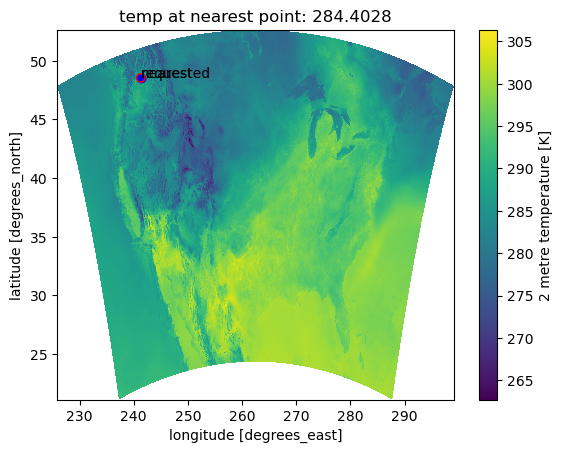

In [6]:
# Desired Lat/Lon pt
lon = points[0][0]
lat = points[0][1]
# Convert to degrees east if HRRR formatted that way
if ds.longitude.attrs['units']=="degrees_east":
    lon = 360 + lon
    # print(lon)
    
# Code modified from B. Blaylock https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
ds.t2m.plot(x='longitude', y='latitude')

abslat = np.abs(ds.latitude-lat)
abslon = np.abs(ds.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_ds = ds.sel(x=yloc, y=xloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
g=plt.scatter(point_ds.longitude, point_ds.latitude, color='r')
g.set_facecolor('none')
plt.text(point_ds.longitude, point_ds.latitude, 'nearest')

plt.title('temp at nearest point: %s' % point_ds.t2m.data)

Text(0.5, 1.0, 'temp at nearest point: 287.2778')

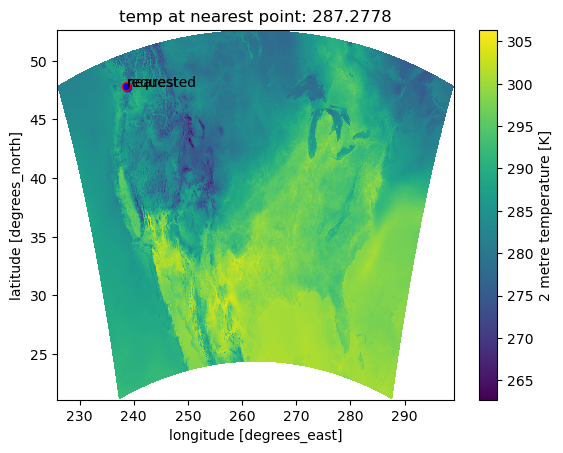

In [7]:
# Desired Lat/Lon pt
lon = points[9][0]
lat = points[9][1]
# Convert to degrees east if HRRR formatted that way
if ds.longitude.attrs['units']=="degrees_east":
    lon = 360 + lon
    # print(lon)|
    
# Code modified from B. Blaylock https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
ds.t2m.plot(x='longitude', y='latitude')

abslat = np.abs(ds.latitude-lat)
abslon = np.abs(ds.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_ds = ds.sel(x=yloc, y=xloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
g=plt.scatter(point_ds.longitude, point_ds.latitude, color='r')
g.set_facecolor('none')
plt.text(point_ds.longitude, point_ds.latitude, 'nearest')

plt.title('temp at nearest point: %s' % point_ds.t2m.data)

### Extract Atmospheric Data with Module Functions

In [8]:
from gather_HRRR import west_to_east

def extract_hrrr(ds, coord, convert_EW=True):
    ## Get variables from the given HRRR layer
    ## Vars include: temp (k), RH
    # ds: xarray object from HRRR, layer could be 2m, 10m, surface
    # coord: tuple of the form (lon, lat)
    # convert_EW: whether or not to convert longitude from E to W. Default True to make compatible with RAWS data

    if ds.longitude.attrs['units']=="degrees_east" and convert_EW:
        coord = west_to_east(coord)
        # print('Converting target longitude to Deg. E')
    
    lon = coord[0][0]
    lat = coord[0][1]
    
    abslat = np.abs(ds.latitude-lat)
    abslon = np.abs(ds.longitude-lon)
    c = np.maximum(abslon, abslat)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    # use that index location to get the values, 
    # NOTE: HRRR requires reorder (y,x)
    point_ds = ds.sel(x=yloc, y=xloc)
    
    return point_ds

In [9]:
## NOTE: compare values to previous plots
extract_hrrr(ds, points[0]).t2m.values

array(284.4028, dtype=float32)

In [10]:
extract_hrrr(ds, points[9]).t2m.values

array(287.2778, dtype=float32)

### Extract Other Layers

Goal is to extract rain, wind, and solar radiation.

#### 10m Vars

Wind is in the 10m layer. The core variables are U and V components of wind, and they are combined (via Pythagoras??) into wind speed (m/s).

In an ML context, initial weights would be:
...

In [11]:
# Read in temp downloaded file from before
ds=xr.open_dataset(
    tempfile,
    filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 10}
)

In [12]:
x10m = extract_hrrr(ds, points[0])

In [13]:
print('East Wind: ', x10m.u10.values)
print('North Wind: ', x10m.v10.values)
print('Wind Speed: ', x10m.si10.values)

East Wind:  -1.490387
North Wind:  -0.4522686
Wind Speed:  1.5662972


#### Surface Vars

Extract rain (accumulated and hourly), solar radiation (up/down & long/short).

In [14]:
# Read in temp downloaded file from before at 2m level
ds=xr.open_dataset(
    tempfile,
    filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant'}
)

In [15]:
xs = extract_hrrr(ds, points[9])

In [16]:
print(xs.dswrf.values)
print(xs.uswrf.values)
print(xs.dlwrf.values)
print(xs.dlwrf.values)
print(xs.prate.values)

0.0
0.0
305.3
305.3
0.0


---

## Slice Needed Layers

Given a HRRR grib file at a particular time, slice off the needed layers and combine into one file. For this project, we get the surface, 2m, and 10m layers using the `xarray` package. This process utilizes a `pandas` dataframe to track which atmospheric variables are needed and which layer they come from.

In [17]:
vs = pd.DataFrame({
    'Common Name': ['temp', 'rh', 
                    'prate', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                    'ewind', 'nwind', 'wind'],
    'HRRR Name': ['t2m', 'r2', 
                  'prate', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                  'u10', 'v10', 'si10'],
    'Layer': ['2m', '2m', 
              'surface','surface','surface','surface','surface',
              '10m', '10m', '10m']
})
vs

,Common Name,HRRR Name,Layer
0,temp,t2m,2m
1,rh,r2,2m
2,prate,prate,surface
3,dswrf,dswrf,surface
4,uswrf,uswrf,surface
5,dlwrf,dlwrf,surface
6,ulwrf,ulwrf,surface
7,ewind,u10,10m
8,nwind,v10,10m
9,wind,si10,10m


In [18]:
ds1, ds2, ds3 = slice_hrrr(tempfile,vs)

NameError: name 'slice_hrrr' is not defined

In [ ]:
# Create subdirectory to save files
dest_dir = datetime.strptime(str(t),'%Y-%m-%dT%H:%M:%S.%f000').strftime("%Y-%m-%d_%H")
os.makedirs(dest_dir, exist_ok=True)
os.chdir(dest_dir)

In [ ]:
ds1.to_netcdf('2m.nc')
ds2.to_netcdf('surf.nc')
ds3.to_netcdf('10m.nc')
os.chdir('..')

---

## Build Timeseries

This next step loops through the hours of the time range given at the beginning of the notebook and,

* temporarily downloads grib file at that date
* extracts values at desired coordinates from temp file to build time series
* delete tempfile before iterating

Variables extracted with a pandas dataframe specifying layer and variable name.

In [ ]:
vs = pd.DataFrame({
    'Common Name': ['temp', 'rh', 
                    'prate', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                    'ewind', 'nwind', 'wind'],
    'HRRR Name': ['t2m', 'r2', 
                  'prate', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                  'u10', 'v10', 'si10'],
    'Layer': ['2m', '2m', 
              'surface','surface','surface','surface','surface',
              '10m', '10m', '10m']
})
vs

In [ ]:
hrrr_dat = gather_hrrr_time_range(
    start = start_time,
    end = end_time,
    pts = points,
    vs = vs
)

In [ ]:
# Compare to viz demo above
print(hrrr_dat[5,0,0])
print(hrrr_dat[5,9,0])

In [ ]:
# Data summary

## Simple func to print summary
def summary(dat):
    ntime = dat.shape[0]
    ncoords = dat.shape[1]
    nvars = dat.shape[2]
    
    print('-'*25)
    print('Sample Size:')
    print('Time: '+str(ntime))
    print('Coordinates: '+str(ncoords))
    print('Atmospheric Vars: '+str(nvars))
    print('-'*25)
    
summary(hrrr_dat)

In [ ]:
# Plot a couple time series at a given pt
temps2 = hrrr_dat[:,2,0]
plt.plot(temps2)

## Write Output

In [ ]:
hrrr_dict={
    'time': pd.date_range(start_time, end_time, freq="1H"),
    'coords': points,
    'data': hrrr_dat
}

In [ ]:
import pickle
with open('hrrr_test.pickle', 'wb') as handle:
    pickle.dump(hrrr_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Sources

* https://registry.opendata.aws/noaa-hrrr-pds/

* https://spire.com/tutorial/spire-weather-tutorial-intro-to-processing-grib2-data-with-python/

* https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md

* https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb

* https://github.com/ecmwf/cfgrib/issues/63

* https://github.com/blaylockbk/Herbie/discussions/45